In [1]:
from typing import Tuple
import numpy as np
import jax.numpy as jnp
from jax import value_and_grad
import jax
import matplotlib.pyplot as plt
import time
from enum import Enum

import mesher
import blob_primitives as blob
import geometry_projection as gp
import FE_routines as fe
import mma
from plotting import plot_bar_primitives, plot_density, plot_history

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [2]:
bounding_box = mesher.BoundingBox(x_min=0., x_max=60.000,
                                  y_min=0., y_max = 30.0000)
mesh = mesher.Mesher(nelx = 40, nely = 20, bounding_box=bounding_box)

plot_bounding_box = mesher.BoundingBox(x_min=-30., x_max=100.000,
                                  y_min=-30., y_max = 50.0000)
plot_mesh = mesher.Mesher(nelx = 600, nely = 300, bounding_box=bounding_box)

In [3]:
material = fe.Material(E = 1., nu = 0.3, rho_min = 1e-3)

In [4]:
# Mid cant beam

force = np.zeros((2*mesh.num_nodes,1))
dofs=np.arange(2*mesh.num_nodes)
fixed = dofs[0:2*(mesh.nely+1):1]
free = jnp.setdiff1d(dofs, fixed)
force[2*(mesh.nelx+1)*(mesh.nely+1)- 1*(mesh.nely+1), 0 ] = -1.


# MBB Beam
# force = np.zeros((2*mesh.num_nodes,1))
# dofs=np.arange(2*mesh.num_nodes)
# fixed= np.union1d(np.arange(0,2*(mesh.nely+1),2), 
#                   2*(mesh.nelx+1)*(mesh.nely+1)-2*(mesh.nely+1)+1)
# force[2*(mesh.nely+1)+1 ,0]= -1.

bc = fe.BC(force = force, fixed_dofs = fixed)

In [5]:
nxb, nyb = 3, 2
num_blobs = nxb*nyb
num_planes_in_a_blob = 6
max_angle_offset = 2*np.pi#/num_planes_in_a_blob
blob_extents = blob.BlobExtents(num_blobs= num_blobs,
                          num_planes_in_a_blob = num_planes_in_a_blob,
                          min_center_x=-0.*mesh.lx, min_center_y=-0.*mesh.ly, 
                          max_center_x=mesh.lx, max_center_y=mesh.ly,
                          min_face_offset=-0.1*mesh.lx, max_face_offset=0.5*mesh.lx,
                          min_angle_offset=0., max_angle_offset= max_angle_offset)

In [6]:
# init_geom = blob.init_random_blobs(blob_extents)

init_geom = blob.init_blob_grid(nxb, nyb, blob_extents)

In [7]:
fe_solver = fe.FEA(mesh, material, bc)
lossfn = fe_solver.loss_function

In [8]:
def plot_blobs_with_different_colors(primitives: blob.ConvexBlob, 
                                     mesh: mesher.Mesher,
                                     status = '', save_fig_as = None, seed: int = 26):
  """
  Each blob gets a different random color.
  """
  
  # get the density of each blob
  sdf = blob.compute_blob_sdf(primitives, mesh, True)
  density = gp.project_primitive_sdf_to_density(sdf, mesh, 100)
  density_union = gp.compute_union_density_fields(density)

  # get a set of random colors for each blob
  clrkey = jax.random.PRNGKey(seed)
  rand_color = jax.random.uniform(clrkey, (density.shape[0], 3))
  
  
  
  red_color = np.zeros((density.shape[0], 4))
  red_color[:,0] = 1.; red_color[:,1] = 0.; red_color[:,2] = 0.; red_color[:,3] = 0.5; 

  # color each blob with different color
  grayness = 0.98 # bg color to slight gray
  composite_img = ( np.clip(
    np.einsum('bc, be -> ec', red_color, density), a_min = 0.05,  a_max=grayness))
  
  
  plot_each_polygon = True
  if plot_each_polygon:
    poly_imgs = ( np.clip(
      np.einsum('bc, be -> bec', red_color, density), a_min = 0.05,  a_max=grayness))
    for p in range(poly_imgs.shape[0]):
      plt.figure()
      plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
      plt.imshow(poly_imgs[p,:,:].reshape((mesh.nelx, mesh.nely, 4)).transpose((1, 0, 2)),
            origin='lower')
      plt.axis('off')
      plt.savefig(f'./frames/poly_{p}.svg')
      
  # #all red color
  # rand_color = rand_color.at[:,0].set(0.);  
  # rand_color = rand_color.at[:,1].set(1.);
  # rand_color = rand_color.at[:,2].set(1.);
  
  # color each blob with different color
  # grayness = 0.9 # bg color to slight gray
  # composite_img = jnp.clip(jnp.einsum('bc, be -> ec', rand_color, density), a_max=grayness)
  # composite_img = grayness*jnp.ones_like(composite_img) - composite_img

  plt.figure()
  plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
  plt.imshow(composite_img.reshape((mesh.nelx, mesh.nely, 4)).transpose((1, 0, 2)),
            origin='lower')
  plt.axis('off')
  
  # plt.axis('equal')

  plt.title(status)
  
  if save_fig_as is not None:
    plt.savefig(save_fig_as)
  plt.show()



# class syntax
class Extremum(Enum):
    MAX = 1
    MIN = 2


def smooth_min(x, order = 100, extreme:Extremum = Extremum.MIN):
  x_nograd = jax.lax.stop_gradient(x)
  scale = np.amax(np.abs(x_nograd))/order
  sgn = -1. if extreme == Extremum.MIN else 1.
  # return scale*sgn*jnp.log(jnp.mean(jnp.exp(sgn*x/scale)))
  return  scale*sgn*jax.scipy.special.logsumexp(sgn*x/scale)

def compute_min_edge_length_of_polygons(primitives: blob.ConvexBlob):
  edge_lengths = blob.compute_edge_lengths_of_polygons(primitives)
  softmin_edge_length = smooth_min(edge_lengths)
  return softmin_edge_length
  

def primitive_to_density(primitives, mesh):

  sdf = blob.compute_blob_sdf(primitives, mesh)
  density = gp.project_primitive_sdf_to_density(sdf, mesh)
  return gp.compute_union_density_fields(density)


class Optimizer:
  def __init__(self, lossfn, mesh, primitive_params: blob.BlobExtents):
    self.lossfn, self.mesh = lossfn, mesh
    self.primitive_params = primitive_params
  #-----------------------#
  def constraint_fn(self, design_variable: jnp.ndarray,
                        max_vol_frac: float,
                        allowed_min_edge_length: float) -> Tuple[jnp.ndarray, jnp.ndarray]:

    def volume_constraint(design_variable:jnp.ndarray)-> float:
      self.geometry = blob.ConvexBlob.from_normalized_array(
            design_variable.reshape((-1)), self.primitive_params)
      if(self.impose_blob_symm):
        self.geometry = blob.impose_blob_symmetry(self.geometry)
      density = primitive_to_density(self.geometry, self.mesh)

      occupied_volume = self.mesh.elem_area*jnp.sum(density)
      volcons =  occupied_volume/(max_vol_frac*self.mesh.domain_volume) - 1.
      return volcons
    vc, dvc = value_and_grad(volume_constraint)(design_variable)

    
    def min_edge_length_constraint(design_variable:jnp.ndarray)-> float:
      polygons = blob.ConvexBlob.from_normalized_array(
            design_variable.reshape((-1)), self.primitive_params)
      min_edge_length = compute_min_edge_length_of_polygons(polygons)
      return 1. - (min_edge_length/allowed_min_edge_length)
    elc, delc = value_and_grad(min_edge_length_constraint)(design_variable)
    
    c = jnp.vstack((vc, elc))
    dc = jnp.hstack((dvc, delc)).T

    return c, dc
  #-----------------------#
  def objective_fn(self, design_var: jnp.ndarray)-> Tuple[jnp.ndarray, jnp.ndarray]:
    

    def deterministic_loss(design_var: jnp.ndarray)->jnp.ndarray:
      self.geometry = blob.ConvexBlob.from_normalized_array(
        design_var.reshape((-1)), self.primitive_params)
      if(self.impose_blob_symm):
        self.geometry = blob.impose_blob_symmetry(self.geometry)
      density = 1e-2 + primitive_to_density(self.geometry, self.mesh)
      compliance, displacement = self.lossfn(density)
      return compliance, (displacement, density)


    (obj, (self.u, self.density)), grad_obj = value_and_grad(deterministic_loss, has_aux=True)(design_var)
    return obj, grad_obj.reshape((-1, 1))
  #-----------------------#
  def optimize(self, init_geom, max_vol_frac: float,
               allowed_min_edge_length: float,
     max_iter: int, kkt_tol: float=1e-6, step_tol: float=1e-6,
      move_limit: float=1e-2, impose_blob_symm: bool = False, plot_interval: int=5):
    obj_time, cons_time, mma_time = 0., 0., 0.
    self.num_design_var = init_geom.num_free_parameters
    self.impose_blob_symm = impose_blob_symm
    self.geometry = init_geom
    self.design_var = self.geometry.to_normalized_array(
      self.primitive_params).reshape((-1, 1))
    lower_bound = np.zeros((self.num_design_var, 1))
    upper_bound = np.ones((self.num_design_var, 1))
    mma_params = mma.MMAParams(
        max_iter=max_iter,
        kkt_tol=kkt_tol,
        step_tol=step_tol,
        move_limit=move_limit,
        num_design_var=self.num_design_var,
        num_cons=2,
        lower_bound=lower_bound,
        upper_bound=upper_bound,
    )
    mma_state = mma.init_mma(self.design_var, mma_params)
    def plotfun(x, status = ''):
      geometry = blob.ConvexBlob.from_normalized_array(
                    x.reshape((-1)), self.primitive_params)
  
      edge_lengths = blob.compute_edge_lengths_of_polygons(geometry)
      softmin_edge_length = smooth_min(edge_lengths)
      min_edge_length = jnp.amin(edge_lengths)
      print(f'actual min_edge_length {min_edge_length:.3F} softmin_edge_length {softmin_edge_length:.3F}')
      
      
      plot_blobs_with_different_colors(geometry, plot_mesh, status=status,
                                      save_fig_as = f'./frames/iter_{mma_state.epoch}.svg')

    history = {'obj':[], 'vol_cons':[], 'edge_len_cons':[]}
    # MMA Loop

    while not mma_state.is_converged:

      start = time.perf_counter()
      objective, grad_obj = self.objective_fn(mma_state.x)
      obj_time += time.perf_counter() - start
      
      start = time.perf_counter()
      constr, grad_cons = self.constraint_fn(mma_state.x, max_vol_frac, allowed_min_edge_length)
      cons_time += time.perf_counter() - start
      
      start = time.perf_counter()
      mma_state = mma.update_mma(
        mma_state, mma_params, objective, grad_obj, constr, grad_cons
      )
      mma_time += time.perf_counter() - start
      
      status = (f'epoch {mma_state.epoch:d} obj {objective:.2E} '
                f'vol cons {constr[0,0]:.2E} edge_len_cons {constr[1,0]:.2E} ')
      history['obj'].append(objective)
      history['vol_cons'].append(constr[0,0])
      history['edge_len_cons'].append(constr[1,0])
      
      print(status)
      if mma_state.epoch%plot_interval == 0 or mma_state.epoch==1:
        plotfun(mma_state.x, status)
      # print(f'obj {obj_time:.2F}, cons {cons_time:.2F} , mma {mma_time:.2F}')
      # Plot current design

    return mma_state, history

hellloooo
hellloooo
epoch 1 obj 2.99E+03 vol cons -7.29E-01 edge_len_cons -1.09E+00 
actual min_edge_length 3.956 softmin_edge_length 3.918


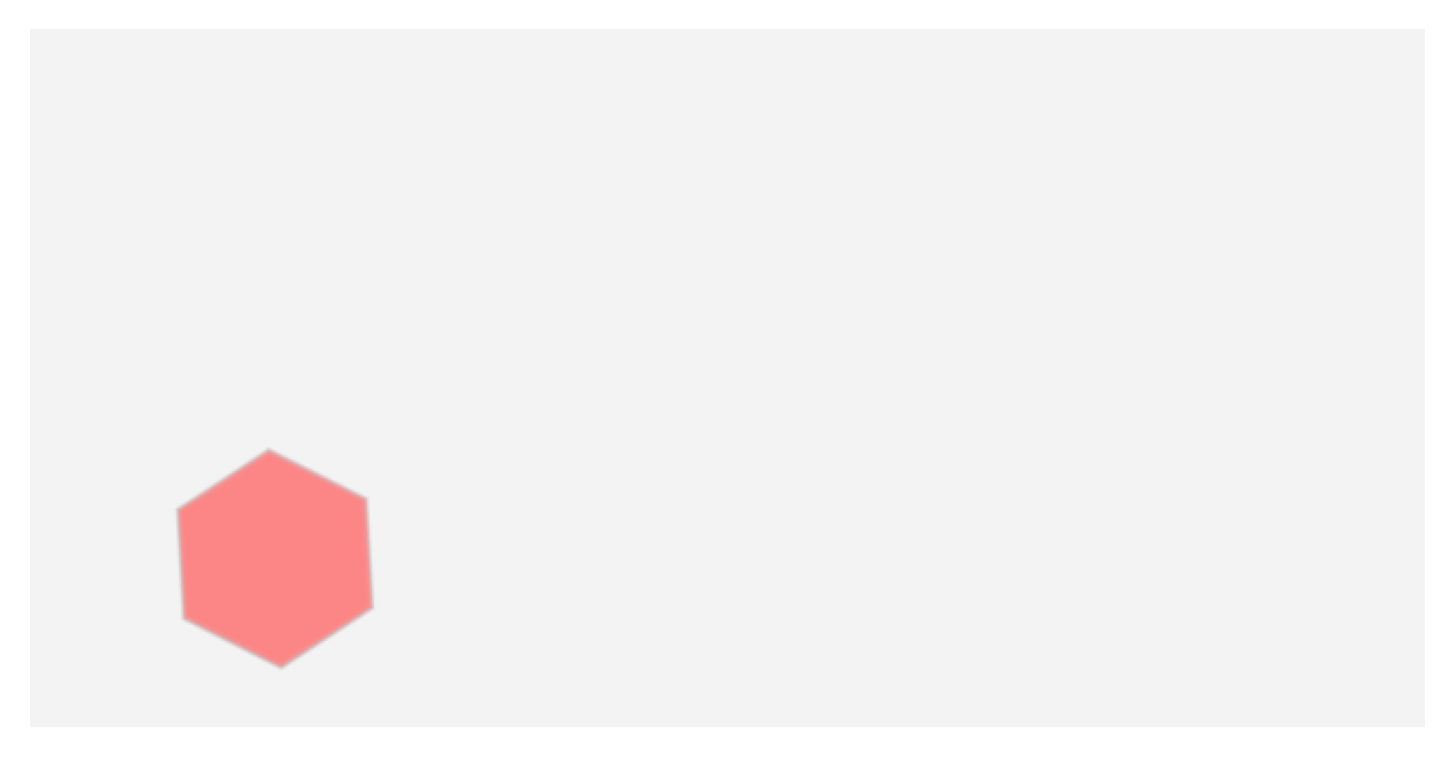

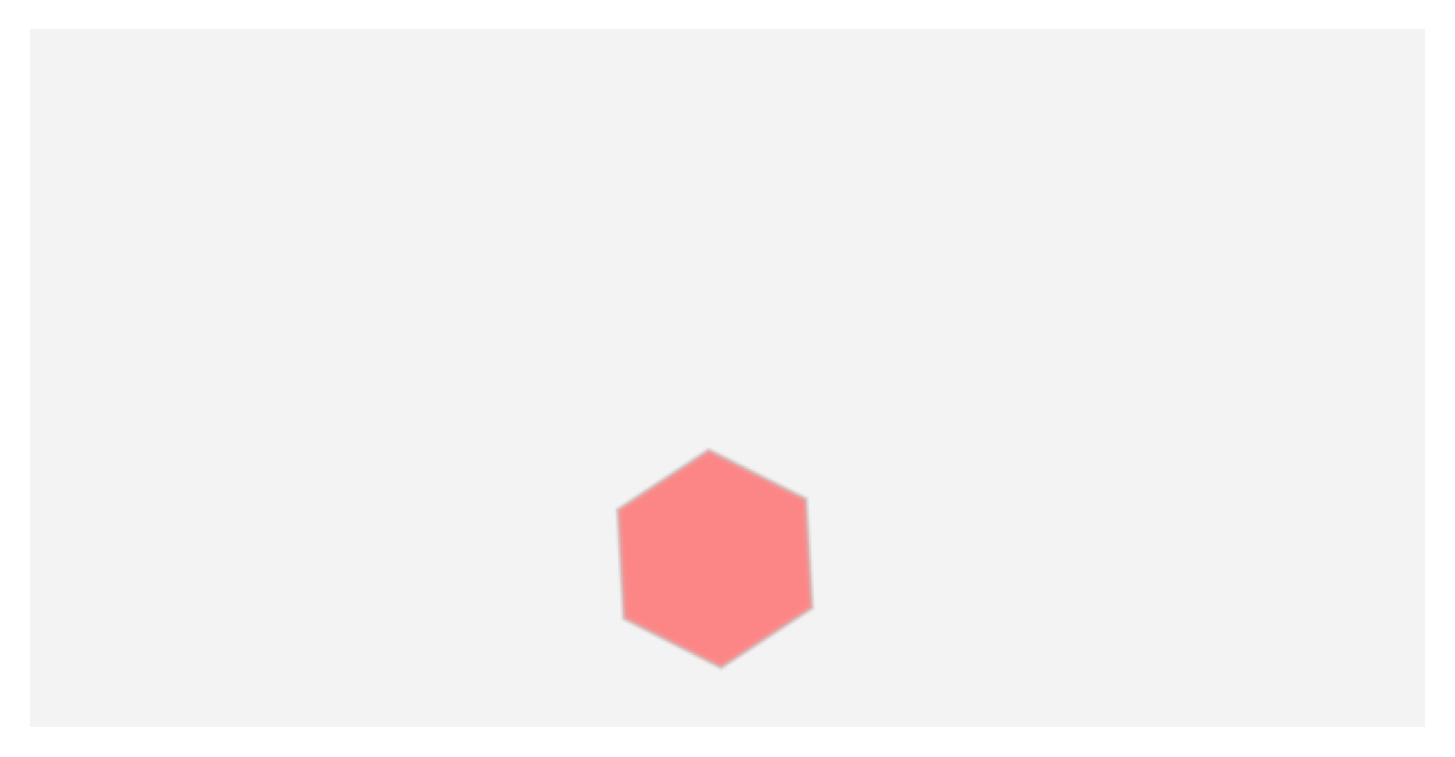

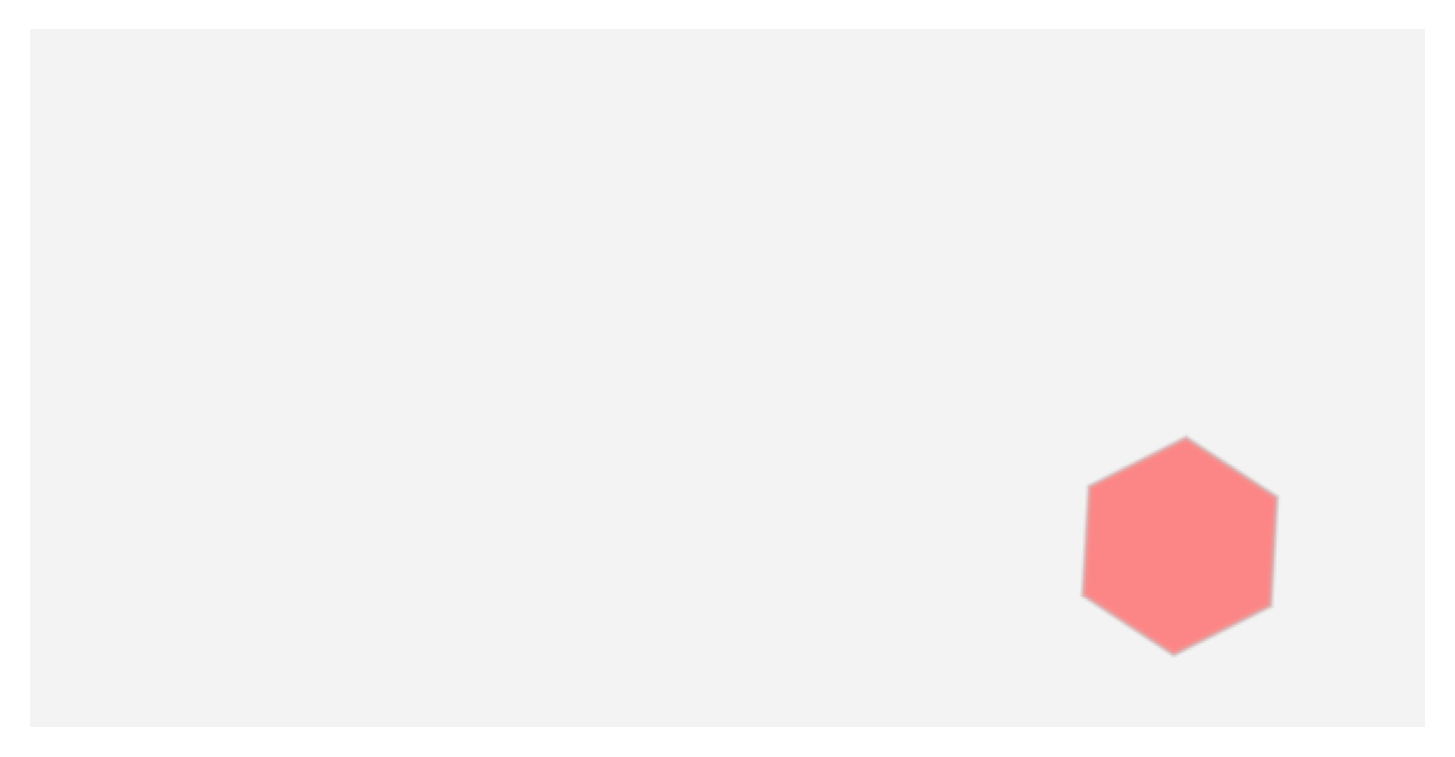

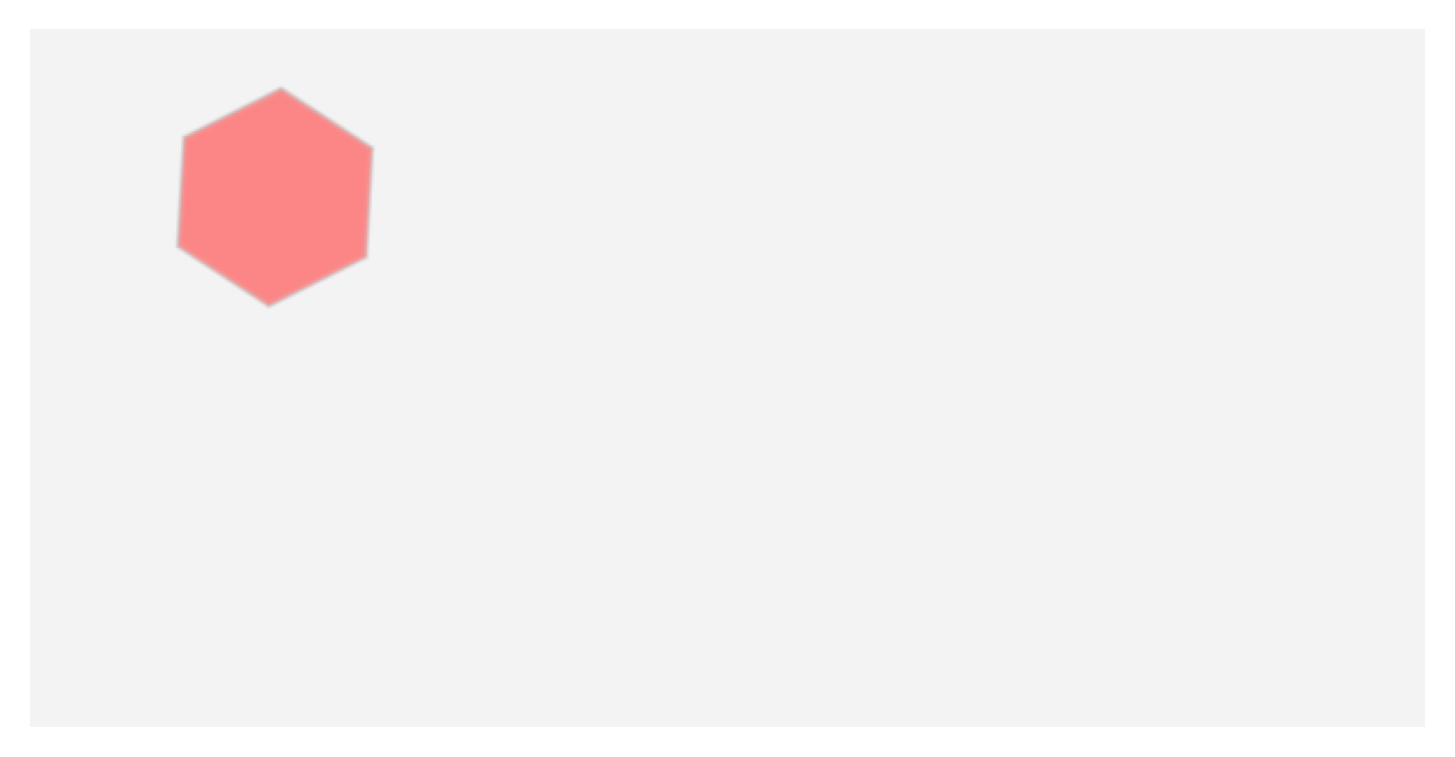

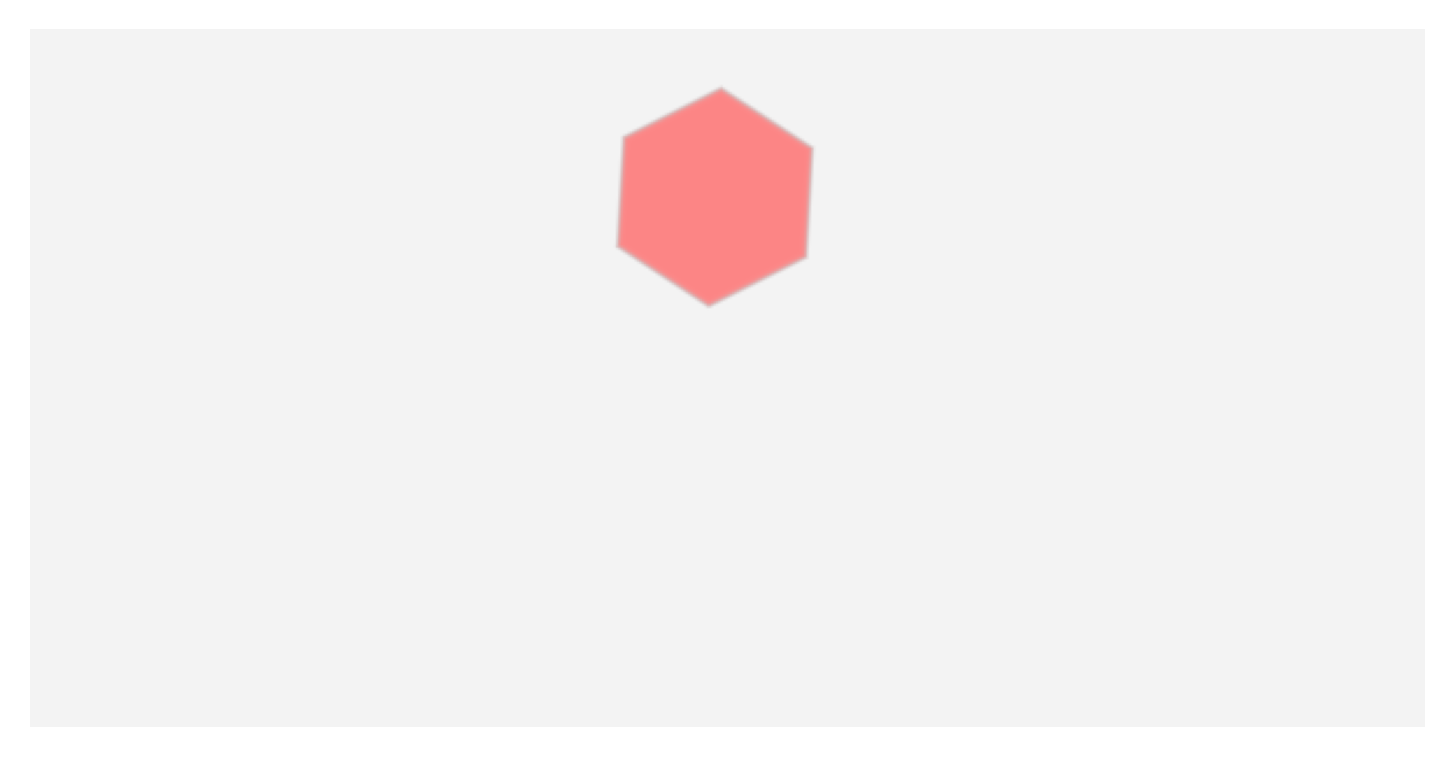

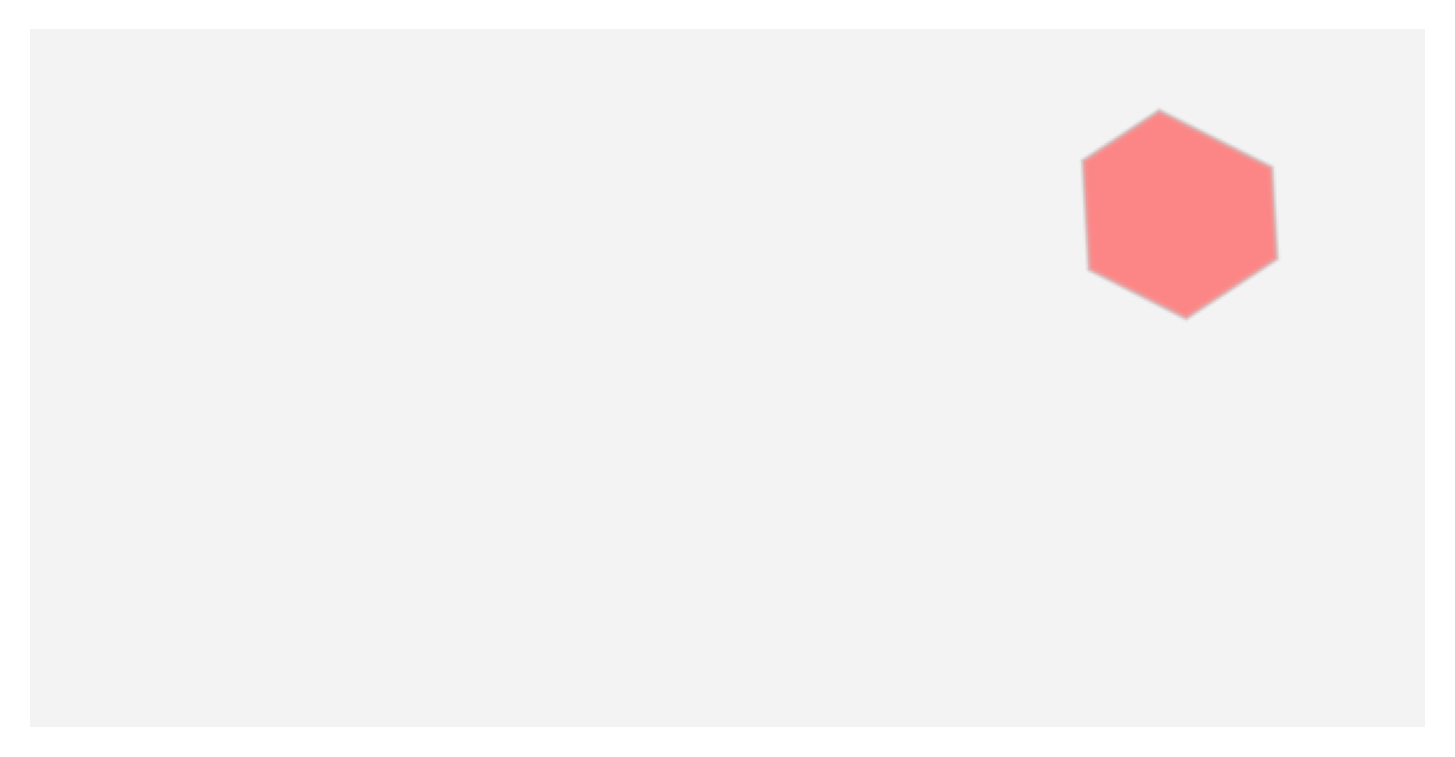

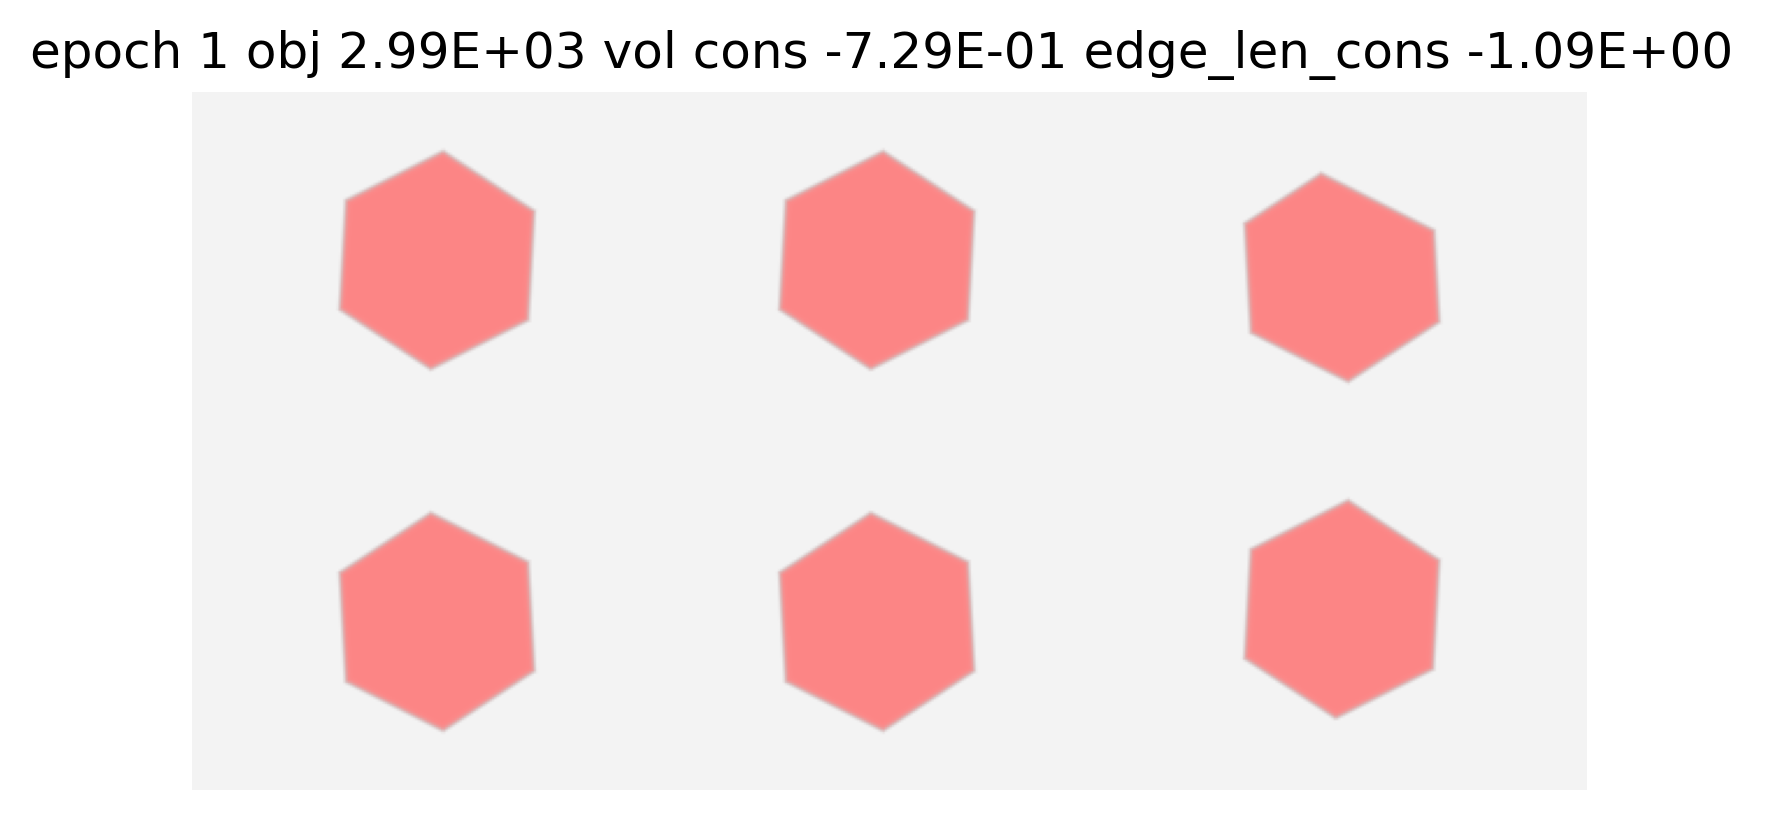

hellloooo
hellloooo
epoch 2 obj 2.82E+03 vol cons -6.84E-01 edge_len_cons -9.59E-01 
hellloooo
hellloooo
epoch 3 obj 2.56E+03 vol cons -6.26E-01 edge_len_cons -1.16E+00 
hellloooo
hellloooo
epoch 4 obj 2.32E+03 vol cons -5.63E-01 edge_len_cons -1.29E+00 
hellloooo
hellloooo
epoch 5 obj 2.16E+03 vol cons -4.89E-01 edge_len_cons -1.44E+00 
hellloooo
hellloooo
epoch 6 obj 1.97E+03 vol cons -4.11E-01 edge_len_cons -1.63E+00 
hellloooo
hellloooo
epoch 7 obj 1.73E+03 vol cons -3.32E-01 edge_len_cons -1.84E+00 
hellloooo
hellloooo
epoch 8 obj 1.53E+03 vol cons -2.55E-01 edge_len_cons -2.04E+00 
hellloooo
hellloooo
epoch 9 obj 1.30E+03 vol cons -1.68E-01 edge_len_cons -2.25E+00 
hellloooo
hellloooo
epoch 10 obj 1.05E+03 vol cons -8.78E-02 edge_len_cons -2.46E+00 
hellloooo
hellloooo
epoch 11 obj 8.73E+02 vol cons -3.01E-02 edge_len_cons -2.08E+00 
hellloooo
hellloooo
epoch 12 obj 6.21E+02 vol cons -2.93E-02 edge_len_cons -1.64E+00 
hellloooo
hellloooo
epoch 13 obj 5.30E+02 vol cons -2.86E-02 e

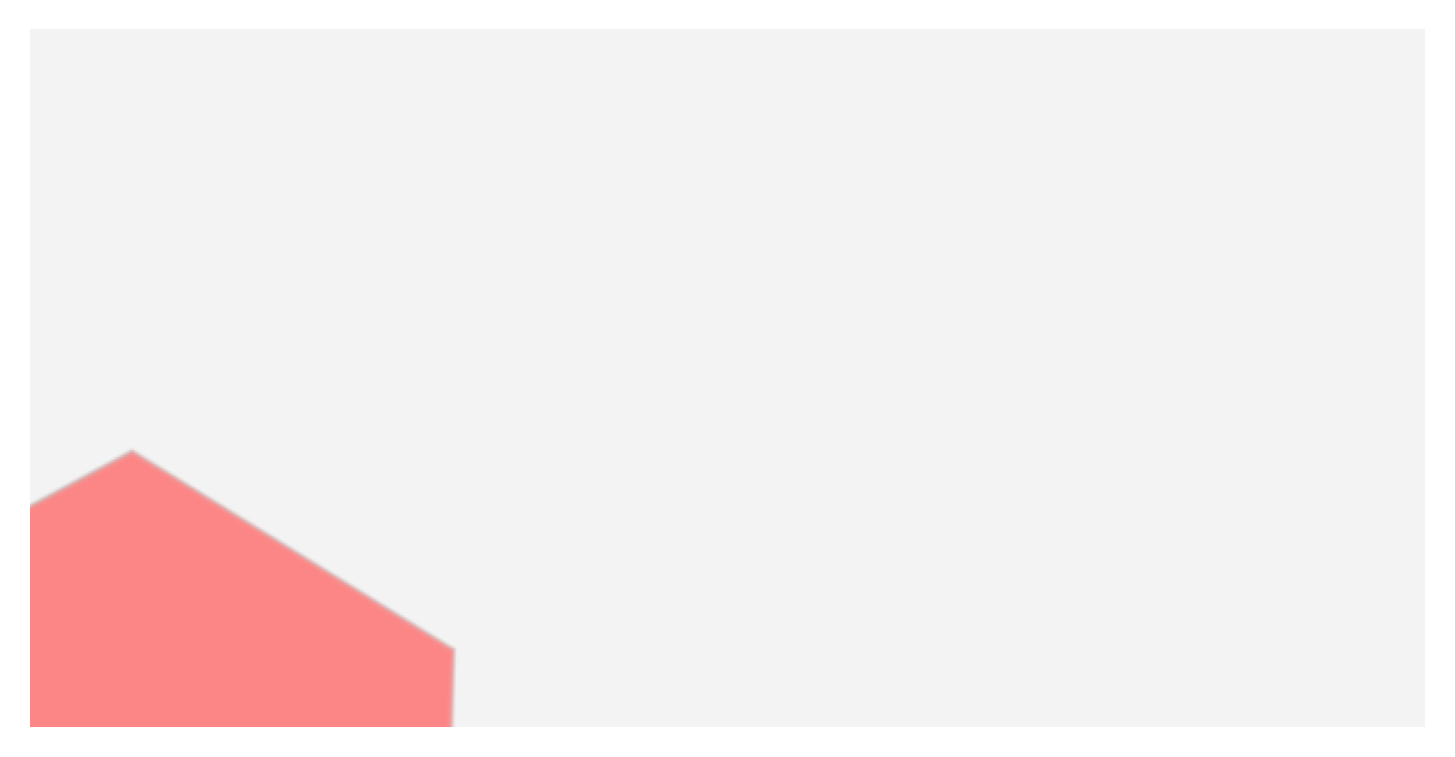

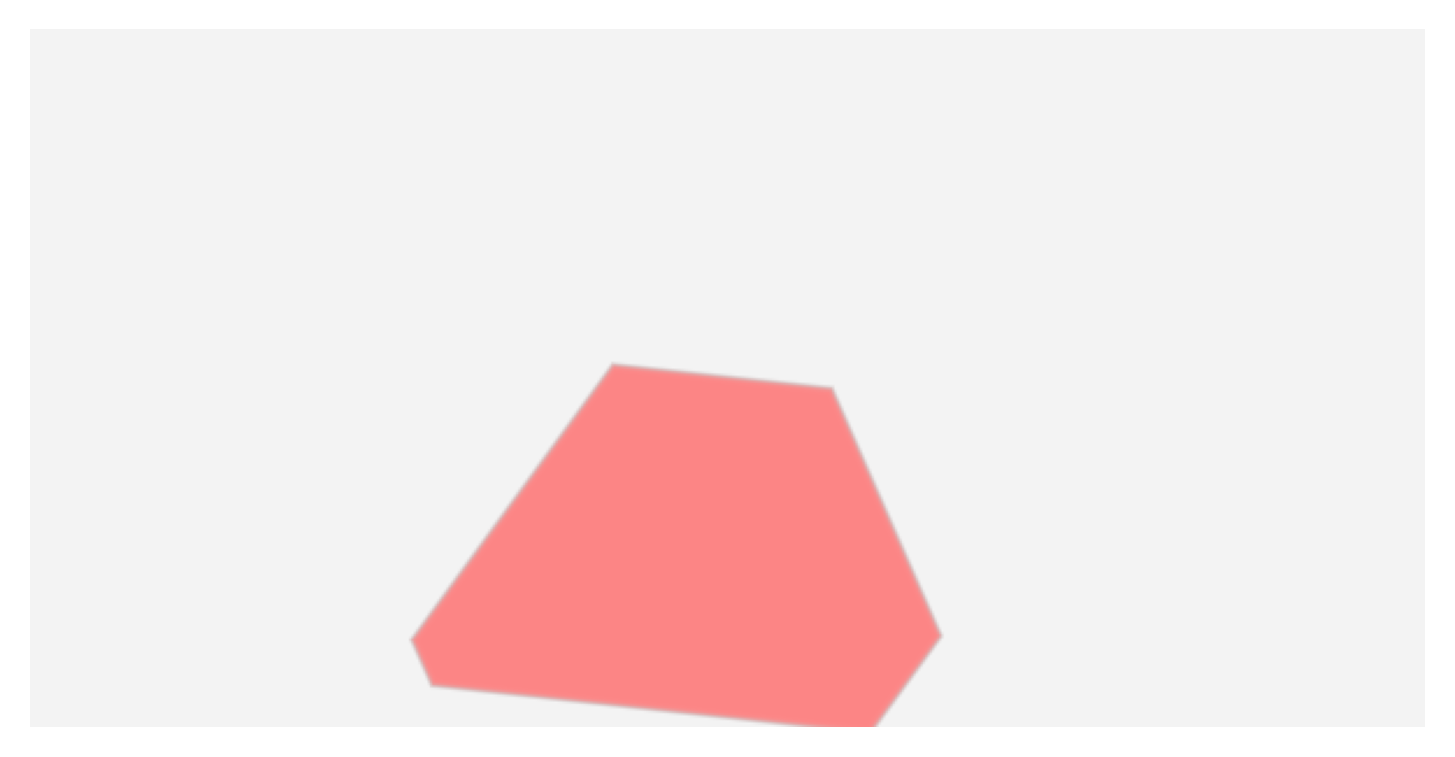

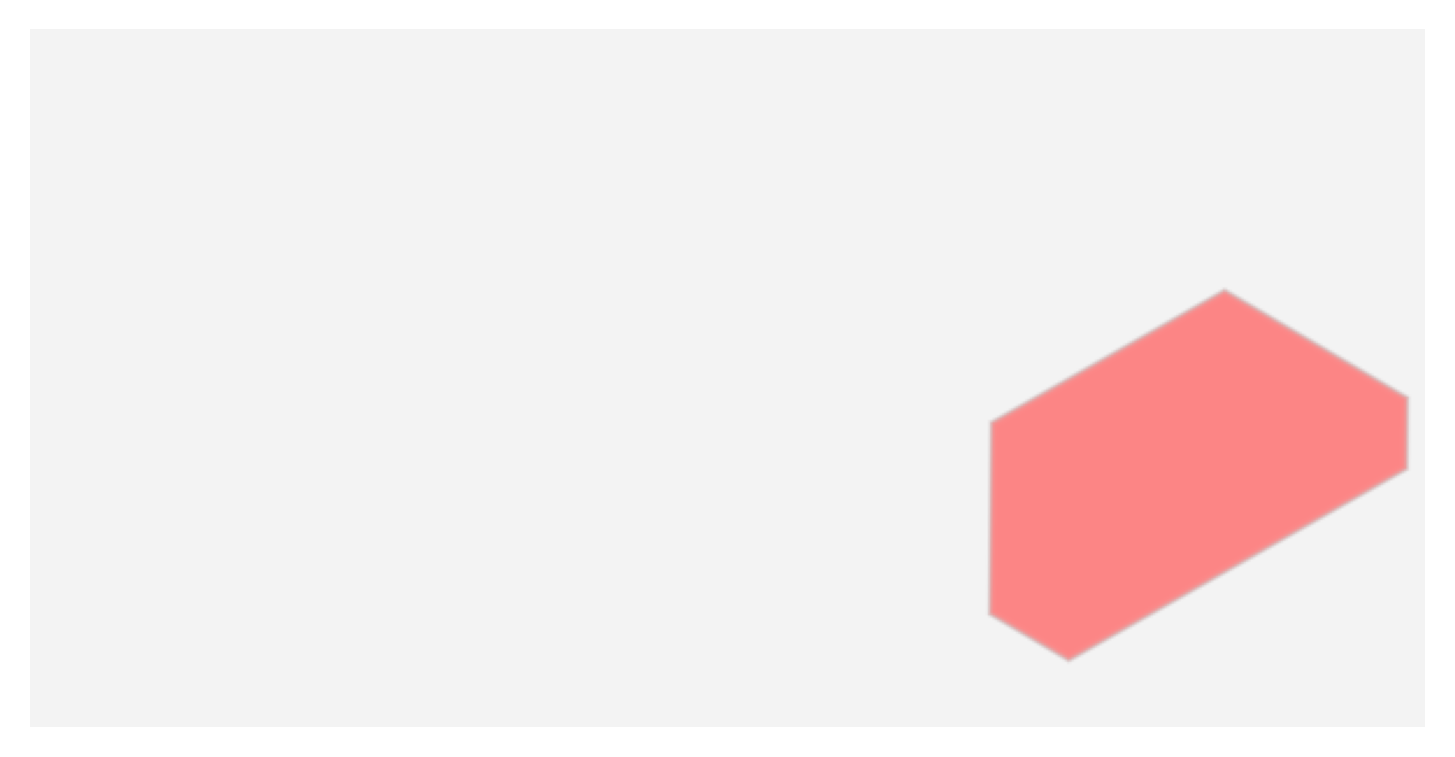

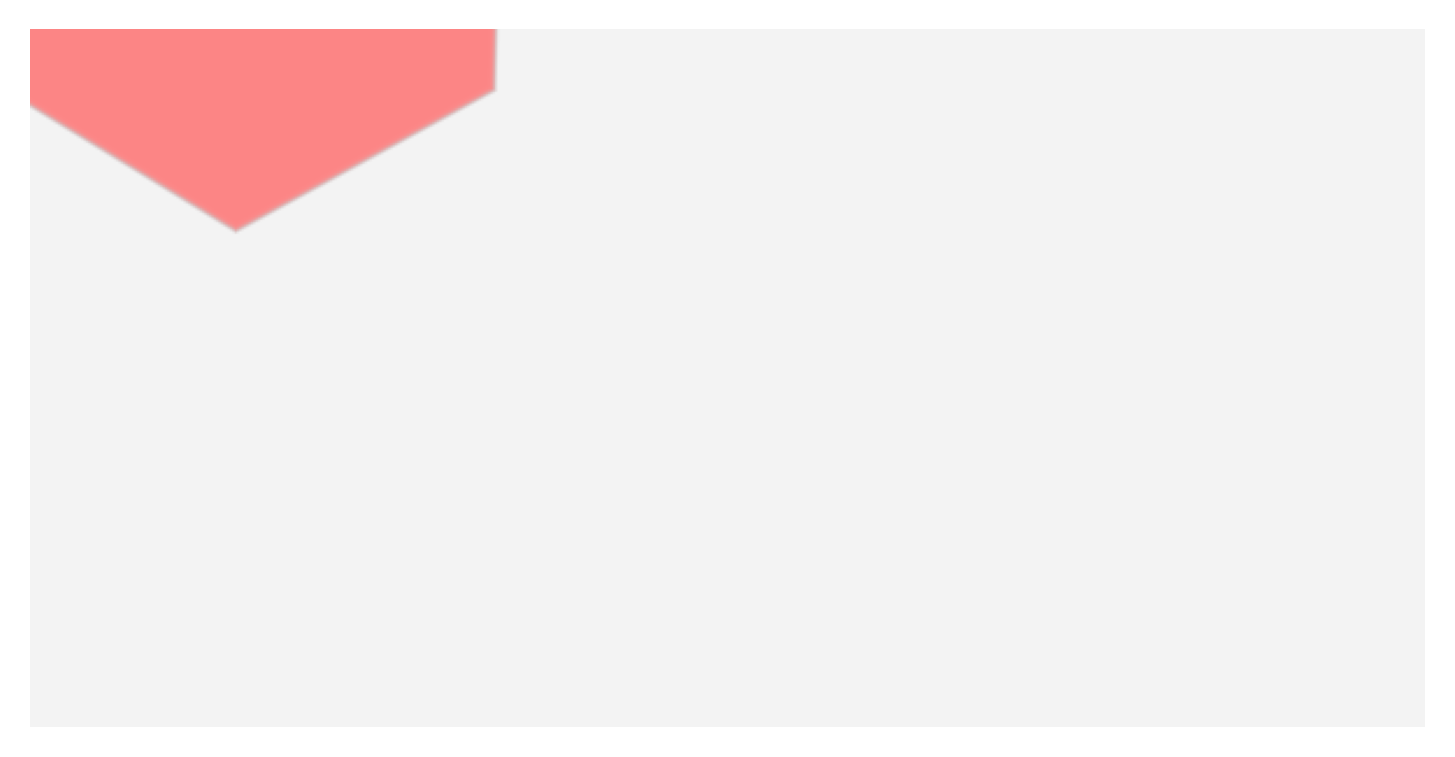

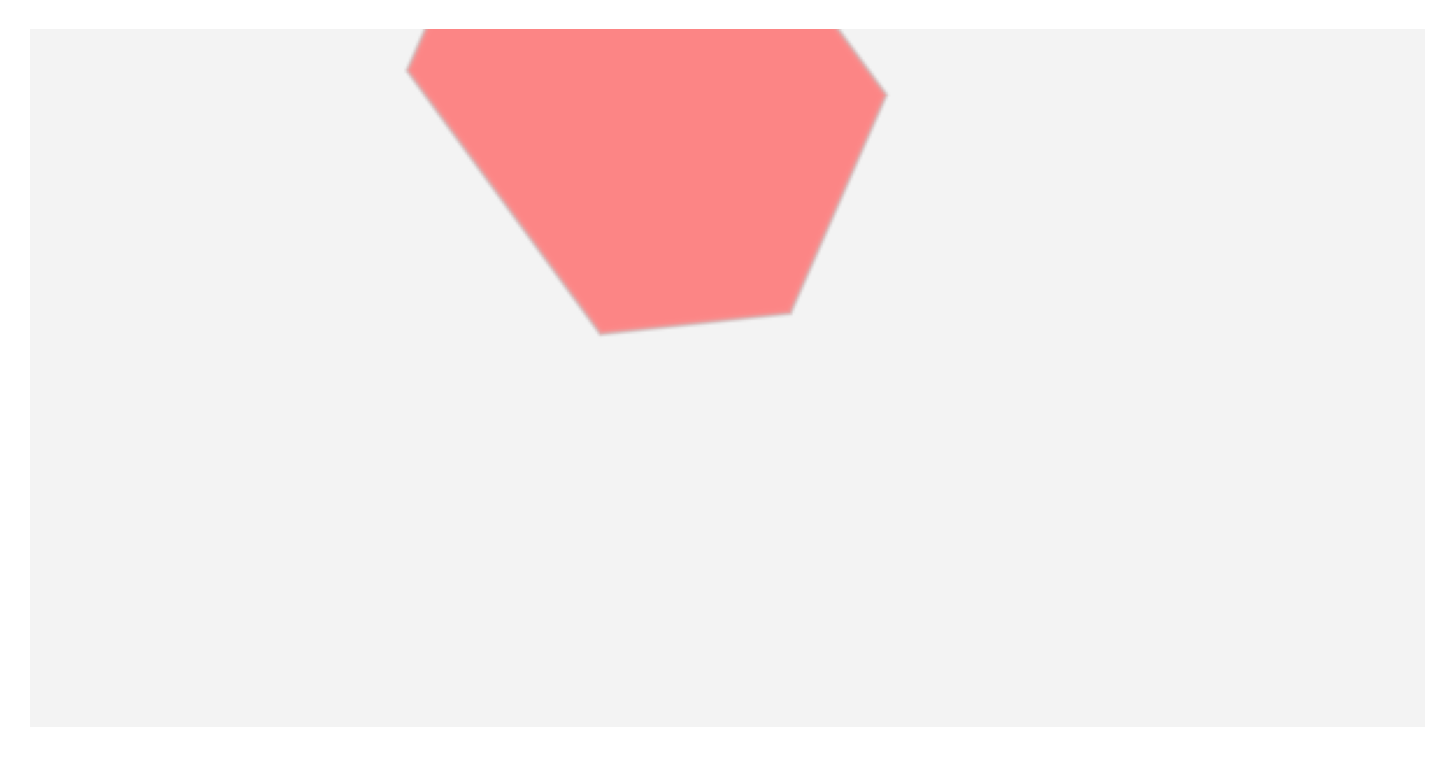

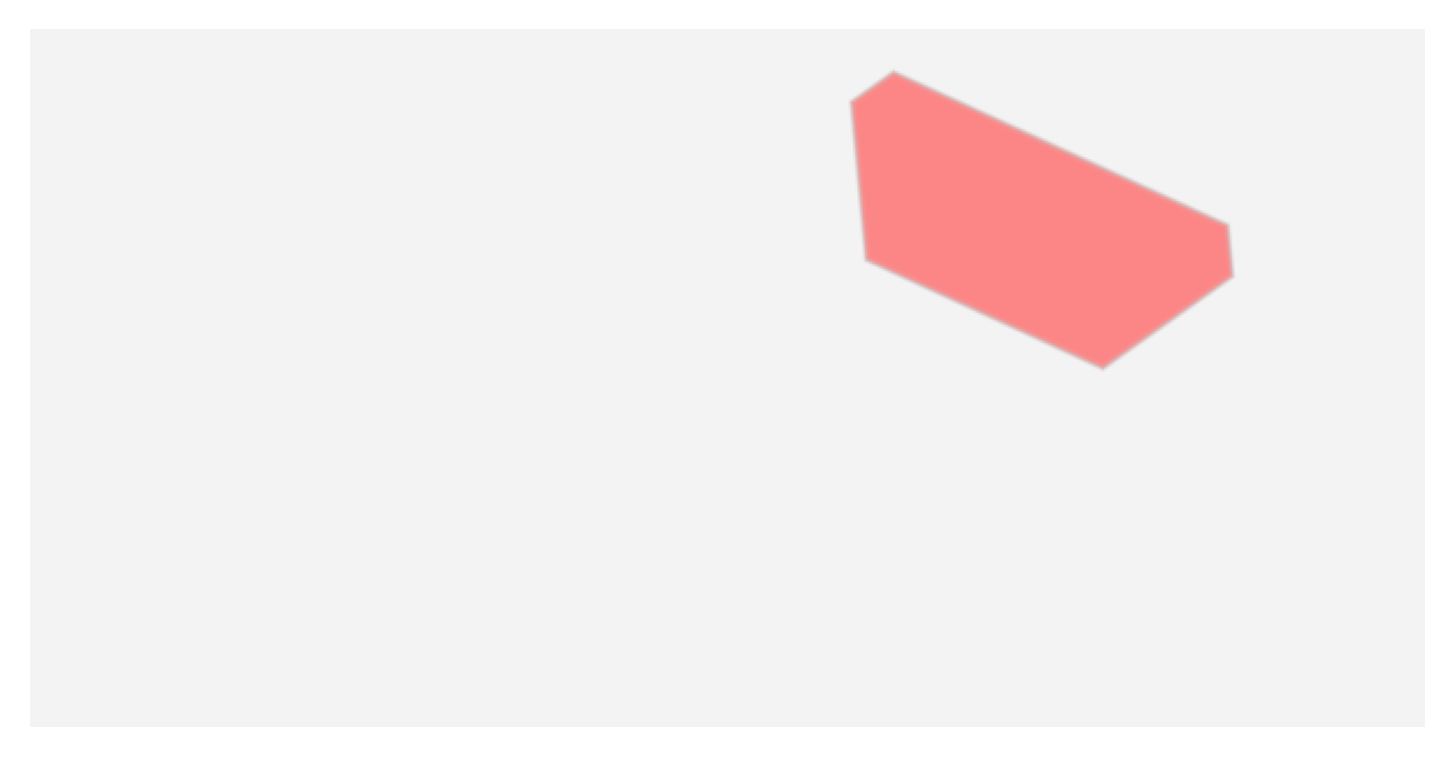

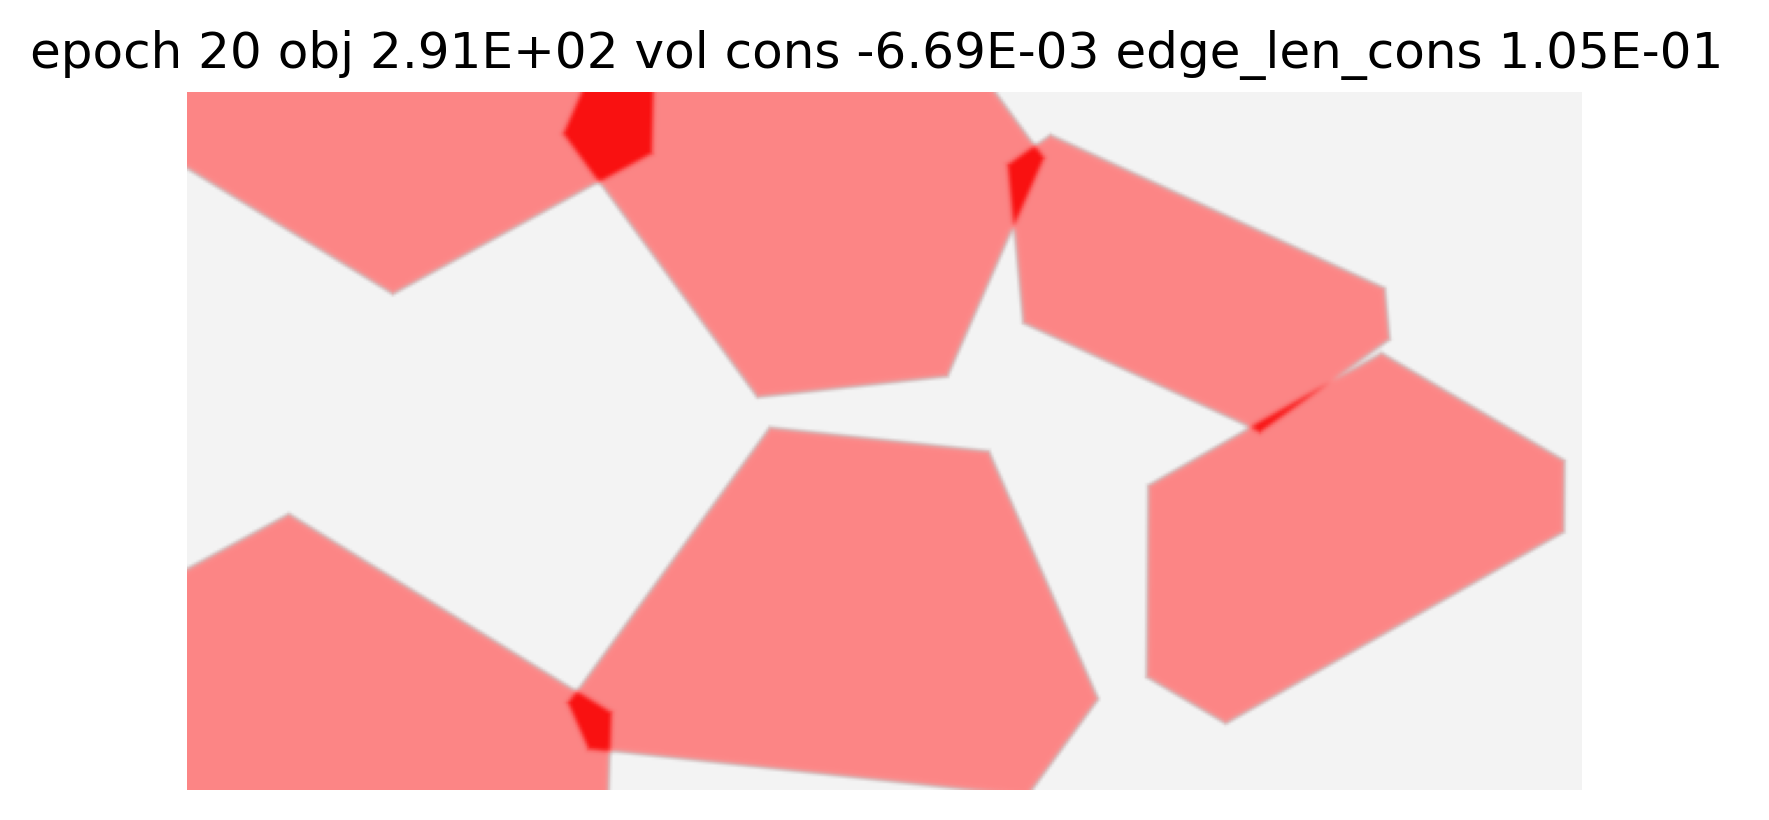

hellloooo
hellloooo
epoch 21 obj 1.69E+02 vol cons -9.60E-03 edge_len_cons -5.37E-04 
hellloooo
hellloooo
epoch 22 obj 1.38E+02 vol cons -1.33E-02 edge_len_cons 3.06E-03 
hellloooo
hellloooo
epoch 23 obj 1.23E+02 vol cons -6.64E-03 edge_len_cons -1.25E-02 
hellloooo
hellloooo
epoch 24 obj 1.20E+02 vol cons -9.25E-03 edge_len_cons 1.34E-02 
hellloooo
hellloooo
epoch 25 obj 1.16E+02 vol cons -1.21E-02 edge_len_cons -2.53E-02 
hellloooo
hellloooo
epoch 26 obj 1.12E+02 vol cons -4.33E-03 edge_len_cons 1.42E-02 
hellloooo
hellloooo
epoch 27 obj 1.10E+02 vol cons -5.95E-03 edge_len_cons -1.54E-02 
hellloooo
hellloooo
epoch 28 obj 1.08E+02 vol cons -3.56E-03 edge_len_cons -7.44E-03 
hellloooo
hellloooo
epoch 29 obj 1.06E+02 vol cons -3.59E-03 edge_len_cons -8.70E-06 
hellloooo
hellloooo
epoch 30 obj 1.04E+02 vol cons -2.39E-03 edge_len_cons 1.31E-01 
hellloooo
hellloooo
epoch 31 obj 1.03E+02 vol cons -1.96E-03 edge_len_cons 5.06E-02 
hellloooo
hellloooo


In [ ]:
optim = Optimizer(lossfn, mesh, blob_extents)
impose_blob_symm = False

## Optimization
start = time.perf_counter()
mma_state, history = optim.optimize(init_geom, max_vol_frac=0.5,
                                    allowed_min_edge_length = 2.,
                                    max_iter=201,
                                    impose_blob_symm=impose_blob_symm,
                                    plot_interval=20)

print('time taken ', time.perf_counter() - start)
plt.show(block=True)

In [ ]:
for k in history:
  plt.figure()
  plt.plot(history[k])
  plt.xlabel('iter')
  plt.ylabel(f'{k}')